In [1]:
from jax.config import config

config.update("jax_enable_x64", True)

import pickle

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.optimize
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from hyperion.utils import ANG_DIST_INT, cherenkov_ang_dist
from torchinterp1d import Interp1d
from tqdm.notebook import tqdm, trange

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

torch.set_default_dtype(torch.float64)

import sys

sys.path.append("../olympus")
from glob import glob
from itertools import product

import awkward as ak
import pandas as pd
from olympus.event_generation import (
    Constants,
    Detector,
    generate_cascade,
    make_hex_grid,
    make_line,
)
from olympus.event_generation.mc_record import MCRecord
from olympus.event_generation.photon_propagation import (
    PhotonSource,
    dejit_sources,
    make_generate_bin_amplitudes_nn,
    make_generate_photons_nn,
    source_to_model_input,
)

from olympus.event_generation.lightyield import fennel_total_light_yield
from hyperion.models.photon_arrival_time.net import PhotonArivalTimePars
from hyperion.models.photon_arrival_time.pdf import make_exp_exp_exp, sample_exp_exp_exp
from jax import jit
from jax import numpy as jnp
from jax import value_and_grad
from numba.typed import List
from torch.autograd.functional import hessian, jacobian

%matplotlib inline

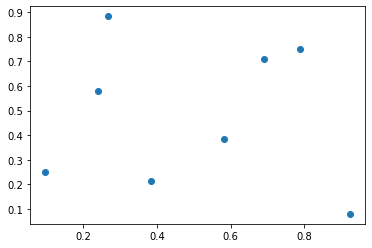

In [2]:
from scipy.stats import qmc

sampler = qmc.Sobol(d=2, scramble=True)

sample = sampler.random_base2(m=3)
plt.scatter(sample[:, 0], sample[:, 1])

In [3]:




"""
lc_links = {}
for i in range(60):
  
    links = list(range(max(i-1, (i//20)*20), min(i+2, (i//20+1)*20)))
    links.remove(i)
    lc_links[i] = links

height = 1500
radius = 200
"""

'\nlc_links = {}\nfor i in range(60):\n  \n    links = list(range(max(i-1, (i//20)*20), min(i+2, (i//20+1)*20)))\n    links.remove(i)\n    lc_links[i] = links\n\nheight = 1500\nradius = 200\n'

In [4]:
def sph_to_cart(theta, phi=0):
    """Transform spherical to cartesian coordinates."""
    x = torch.sin(theta) * torch.cos(phi)
    y = torch.sin(theta) * torch.sin(phi)
    z = torch.cos(theta)

    out = torch.empty(3, device=device, dtype=torch.float64)
    out[0] = x
    out[1] = y
    out[2] = z

    return out


def sph_to_cart_np(theta, phi=0, r=1):
    """Transform spherical to cartesian coordinates."""
    x = np.sin(theta) * np.cos(phi)
    y = np.sin(theta) * np.sin(phi)
    z = np.cos(theta)

    return np.asarray([x, y, z])

In [5]:
def source_to_model_input_torch(
    module_coords, source_pos, source_dir, source_t0, c_vac, n_gr
):
    """Convert photon sources an module coordinates into neural net input."""

    #source_pos = np.empty((len(sources), 3))
    #source_amp = np.empty(len(sources))
    #source_dir = np.empty((len(sources), 3))
    #source_t0 = np.empty((len(sources)))

    source_targ_vec = module_coords[np.newaxis, ...] - source_pos[:, np.newaxis, :]
    dist = torch.linalg.norm(source_targ_vec, axis=-1)
    angles = torch.arccos(torch.einsum("abk, ak -> ab", source_targ_vec, source_dir) / dist)

    time_geo = dist / (c_vac / n_gr) + source_t0[:, np.newaxis]

    inp_pars = torch.stack(
        [
            torch.tensor(angles.ravel(), dtype=torch.float, device=device),
            torch.tensor(np.log10(dist.ravel()), dtype=torch.float, device=device),
        ],
        dim=-1,
    )
    
    
    
    """
    source_targ_vec = module_coords - source_pos
    dist = torch.linalg.norm(source_targ_vec, dim=-1)
    angles = torch.arccos(
        torch.einsum("ak, k -> a", source_targ_vec, source_dir) / dist
    )
    time_geo = dist / (c_vac / n_gr) + source_t0

    inp_pars = torch.stack([angles, torch.log10(dist)], axis=1)
    return inp_pars, time_geo
    """


def expon_pdf(x, a):
    """Exponential PDF."""
    return 1 / a * torch.exp(-x[:, np.newaxis] / a)


def expon_int(x, a):
    """Exponential CDF"""
    return 1 - torch.exp(-x[:, np.newaxis] / a)


def weight_param(w1, w2):
    weights = torch.empty((w1.shape[0], 3), device=device)
    weights[:, 0] = torch.sin(w1) * torch.cos(w2)
    weights[:, 1] = torch.sin(w1) * torch.sin(w2)
    weights[:, 2] = torch.cos(w1)
    weights = weights ** 2
    return weights


def triple_exp(xs, parameters):

    scales = parameters[:, 0:3] * 100
    scales, indices = torch.sort(scales, dim=1)
    w1 = parameters[:, 3]
    w2 = parameters[:, 4]

    weights = weight_param(w1, w2)

    res = torch.log(
        weights[:, 0] * expon_pdf(xs, scales[:, 0])
        + weights[:, 1] * expon_pdf(xs, scales[:, 1])
        + weights[:, 2] * expon_pdf(xs, scales[:, 2])
    )

    return res


def triple_exp_integral(tmax, parameters):

    scales = parameters[:, 0:3] * 100
    scales, indices = torch.sort(scales, dim=1)
    w1 = parameters[:, 3]
    w2 = parameters[:, 4]
    weights = weight_param(w1, w2)

    res = (
        weights[:, 0] * expon_int(tmax, scales[:, 0])
        + weights[:, 1] * expon_int(tmax, scales[:, 1])
        + weights[:, 2] * expon_int(tmax, scales[:, 2])
    )

    return res


def uniform_triple_exp(xs, parameters):
    log_usf = parameters[:, -2]
    usf = 1 - 10 ** (-log_usf)

    unif = torch.log(usf * 1 / 2)
    texp = torch.log(1 - usf) + triple_exp(
        xs + 2, parameters[:, :-2]
    )  # TODO: Check +2!

    out = torch.where((xs < 2)[:, np.newaxis], unif, texp)

    return out

def uniform_triple_exp_int(tmax, parameters):
    log_usf = parameters[:, -2]
    usf = 1 - 10 ** (-log_usf)

    unif_int = usf * tmax / 2
    texp_int = (1 - usf) * triple_exp_integral(
        tmax, parameters[:, :-2]
    )  # TODO: Check +2!

    out = torch.where(tmax < 2, unif_int, texp_int + usf)

    return out


net = torch.load("data/arival_time_pars_net.dat")
net.to("cuda")
net.eval()


def eval_dist(
    times, amp_exp, pos, theta, phi, t0, module_ix, module_positions, mod_eff=0.3
):
    cdir = sph_to_cart(theta, phi)
    model_in, tgeo = source_to_model_input_torch(
        module_positions, pos, cdir, t0, 0.3, 1.35
    )
    pdf_params = net(model_in).reshape(module_positions.shape[0], 9)[:, :7]

    twindow = torch.tensor(1000, device=device, dtype=torch.float64)  # TODO: Improve

    nnoise = dark_noise_rate * twindow
    amp_meas = times.shape[0]

    log_nph = pdf_params[module_ix, -1]
    surv_ratio = 10 ** log_nph / 300e7
    n_ph_exp = amp_exp * surv_ratio * mod_eff

    times = times - tgeo[module_ix]
    tres_lh = torch.empty(times.shape, device=device)

    noise_term = torch.full(times.shape, torch.log(nnoise), device=device)

    trespdf_eval = torch.logsumexp(
        torch.stack(
            (
                uniform_triple_exp(times, pdf_params[module_ix][np.newaxis, :])[:, 0]
                + torch.log(n_ph_exp),
                noise_term,
            ),
            dim=-1,
        ),
        dim=-1,
    )

    tres_lh = torch.where(times >= 0, trespdf_eval, noise_term)

    return tres_lh, n_ph_exp


def eval_likelihood(
    net, event, amp_exp, pos, theta, phi, t0, module_positions, mod_eff=0.3
):

    cdir = sph_to_cart(theta, phi)
    model_in, tgeo = source_to_model_input_torch(
        module_positions, pos, cdir, t0, 2.99792458e8 * 1e-9, 1.35634
    )
    pdf_params = net(model_in.float()).reshape(module_positions.shape[0], 7).double()

    likelihood = 0
    for i, times in enumerate(event):
        if len(times) == 0:
            continue
        times = torch.tensor(times, device=device, dtype=torch.float64) - tgeo[i]
        twindow = torch.tensor(
            1000, device=device, dtype=torch.float64
        )  # TODO: Improve
        nnoise = dark_noise_rate * twindow

        log_nph = pdf_params[i, -1]
        surv_ratio = 10 ** log_nph / 300e7
        n_ph_exp = amp_exp * surv_ratio * mod_eff

        tres_lh = torch.empty(times.shape, device=device)

        noise_term = torch.full(times.shape, torch.log(nnoise), device=device)

        trespdf_eval = torch.logsumexp(
            torch.stack(
                (
                    uniform_triple_exp(times, pdf_params[i][np.newaxis, :])[:, 0]
                    + torch.log(n_ph_exp),
                    noise_term,
                ),
                dim=-1,
            ),
            dim=-1,
        )

        tres_lh = torch.where(times >= 0, trespdf_eval, noise_term)

        likelihood += tres_lh.sum() - n_ph_exp

    return likelihood


interpolator = Interp1d()


def eval_binned_likelihood(
    net, event , energy_exp, pos, theta, phi, t0, module_positions, mod_eff=0.3
):
    bin_width = torch.diff(binning)[0]
    nbins = len(binning) - 1
    cdir = sph_to_cart(theta, phi)
        
    
    model_in, tgeo = source_to_model_input_torch(
        module_positions, pos, cdir, t0, 2.99792458e8 * 1e-9, 1.35634
    )
    log_pred_amps = (
        net(model_in.float()).reshape(module_positions.shape[0], nbins).double()
    )

    amplitude, tshift = event
    amplitudes = amplitude.detach()

    tshift = tshift.squeeze()
    # prediction is always relative to tres = t -t0 -tgeo
    # thypo = t0 + geo
    # histogram always starts at t0 + t_geo

    # offset > 0 means tshift > tgeo, ie data start *later* than prediction
    # hence the 0 data bin needs to be evaluated against the +offset bin of prediction
    # or prediction has to be shifted by -offset
    offset = torch.floor((tgeo[0] - tshift[0]) / bin_width).int()

    offset = torch.clamp(offset, -200, 200)
    print(offset)

    photons_exp = fennel_total_light_yield(energy_exp, 11)

    # pred_amps = 10**log_pred_amps / 300E7 * amp_exp
    log_pred_amps_rsc = log_pred_amps + torch.log(photons_exp)
    target_low = torch.max(
        torch.stack([torch.tensor(0, device=device), -offset]), dim=0
    )[0]
    target_high = torch.min(
        torch.tensor([log_pred_amps.shape[1], log_pred_amps.shape[1] - offset]), dim=0
    )[0]

    src_low = torch.max(torch.stack([torch.tensor(0, device=device), offset]), dim=0)[0]
    src_high = torch.min(
        torch.tensor([log_pred_amps.shape[1], log_pred_amps.shape[1] + offset]), dim=0
    )[0]

    offset_pred_amps = torch.full(
        (nbins, tshift.shape[0]), dark_noise_rate * bin_width, device=device
    )
    offset_pred_amps[target_low:target_high, :] += log_pred_amps_rsc[
        :, src_low:src_high
    ].T

    eval_grid = binning[:-1]  # [:, np.newaxis] + tshift
    fractional = (tgeo[0] - tshift[0]) / bin_width - offset

    interpolated = (
        offset_pred_amps[:-1]
        + fractional * torch.diff(offset_pred_amps, dim=0) / bin_width
    )

    interp_log_amp = interpolated.T
    llh = -torch.exp(interp_log_amp) + amplitude[0][:, :-1] * interp_log_amp

    return llh.sum()

In [6]:
rng = np.random.RandomState(31338)
oms_per_line = 20
dist_z = 50
dark_noise_rate = 16 * 1e-5  # 1/ns
det = make_triang(100, oms_per_line, dist_z, dark_noise_rate, rng)
module_positions = torch.tensor(det.module_coords, dtype=torch.float64, device=device)

side_len = 100

theta = np.radians(30)
phi = np.radians(10)
event_dir = sph_to_cart_np(theta, phi)
pos = np.asarray([50.0, side_len / (2 * np.sqrt(3)), 0])
t0_gen = 20

energy_gen = 100e3
n_ph_gen = energy_gen * (5.3 * 250 * 1e2)


gen_ph = make_generate_photons_nn(
    "../hyperion/data/arival_time_pars_net_w_arriv_pos.dat"
)

# phsrc = PhotonSource(pos, amp_gen, 0, cdir)
# samples = gen_ph(det.module_coords, det.module_efficiencies, [phsrc])

theta_t = torch.tensor(theta, device=device, dtype=torch.float64)
event_dir_t = torch.tensor(event_dir, device=device, dtype=torch.float64)
phi_t = torch.tensor(phi, device=device, dtype=torch.float64)
pos_t = torch.tensor(pos, device=device, dtype=torch.float64)
n_ph_gen_t = torch.tensor(n_ph_gen, device=device, dtype=torch.float64)
energy_gen_et = torch.tensor(energy_gen, device=device, dtype=torch.float64)
t0_gen_t = torch.tensor(t0_gen, device=device, dtype=torch.float64)

In [18]:
amp_gen_func = make_generate_bin_amplitudes_nn("../hyperion/data/arrival_hist_net_0tts.dat")
#binning = binning.to(device)
#generate_cascade_amplitudes = make_generate_cascade_amplitudes(amp_gen_func)

event_data = {"t0": t0_gen, "theta": theta, "phi": phi, "pos": pos, "energy": energy_gen, "pid": 11}

event, record = generate_cascade(
    det, event_data["pos"], event_data["t0"], event_dir, energy=event_data["energy"], particle_id=event_data["pid"], pprop_func=amp_gen_func)

event_amp, event_tshift = event

"""
event_amp_noise = event_amp + dark_noise_rate * torch.diff(binning)[0]

binned_net, _ = torch.load("../hyperion/data/arrival_hist_net_0tts.dat")
binned_net.eval()
llh = eval_binned_likelihood(
    binned_net, binning, event, energy_gen_et, pos_t, theta_t, phi_t, t0_gen_t, module_positions
)
"""

../olympus/olympus/event_generation/photon_propagation.py:430: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return (samples, torch.tensor(time_geo, device=device))


'\nevent_amp_noise = event_amp + dark_noise_rate * torch.diff(binning)[0]\n\nbinned_net, _ = torch.load("../hyperion/data/arrival_hist_net_0tts.dat")\nbinned_net.eval()\nllh = eval_binned_likelihood(\n    binned_net, binning, event, energy_gen_et, pos_t, theta_t, phi_t, t0_gen_t, module_positions\n)\n'

In [10]:
print(len(event_amp[3]))

2


[]

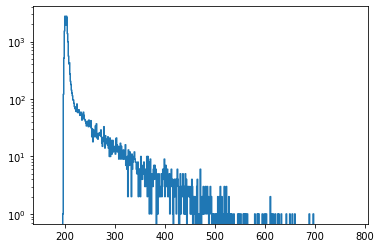

In [15]:
plt.step(event_amp[30][1].detach().cpu(), np.append(event_amp[30][0].detach().cpu(), event_amp[30][0].detach().cpu()[-1]), where="post")
plt.semilogy()
#plt.xlim(20, 100)

In [9]:
ttt = torch.tensor(21.0, requires_grad=True, device=device)
llh = eval_binned_likelihood(
    binned_net, binning, event, energy_gen_et, pos_t, theta_t, phi_t, ttt, module_positions
)
llh.backward()
ttt.grad

ttt = torch.tensor(21.5, requires_grad=True, device=device)
llh = eval_binned_likelihood(
    binned_net, binning, event, energy_gen_et, pos_t, theta_t, phi_t, ttt, module_positions
)
llh.backward()
ttt.grad

tensor(-30254.8362, device='cuda:0')

[]

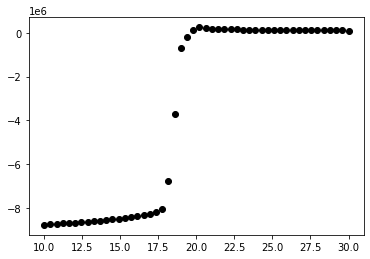

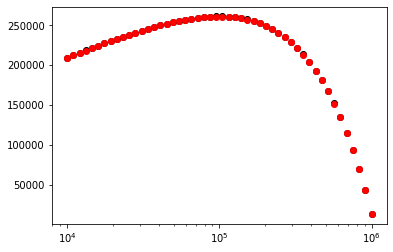

In [10]:
ts = np.linspace(10, 30, 50)

plt.figure()
for t in ts:
    plt.plot(
        t,
        eval_binned_likelihood(
            binned_net,
            binning,
            event,
            energy_gen_et,
            pos_t,
            theta_t,
            phi_t,
            torch.tensor(t, device=device),
            module_positions,
        )
        .detach()
        .cpu(),
        "ok",
    )

es = np.logspace(4, 6, 50)
plt.figure()
for e in es:
    plt.plot(
        e,
        eval_binned_likelihood(
            binned_net,
            binning,
            event,
            torch.tensor(e, device=device),
            pos_t,
            theta_t,
            phi_t,
            t0_gen_t,
            module_positions,
        )
        .detach()
        .cpu(),
        "ok",
    )
    
    plt.plot(
        e,
        eval_binned_likelihood(
            binned_net,
            binning,
            (event_amp_noise, event_tshift),
            torch.tensor(e, device=device),
            pos_t,
            theta_t,
            phi_t,
            t0_gen_t,
            module_positions,
        )
        .detach()
        .cpu(),
        "or",
    )
plt.semilogx()

In [17]:
def dpsi(zen1, azi1, zen2, azi2):
    v1 = sph_to_cart(zen1, azi1)
    v2 = sph_to_cart(zen2, azi2)
    return np.arccos(np.dot(v1, v2))

In [18]:
def make_obj_func(net, event, llh, module_positions):
    def func(pars):
        pars = torch.tensor(pars, device=device, dtype=torch.float, requires_grad=True)

        val = -llh(
            net,
            event,
            10 ** pars[0],
            pars[1:4],
            pars[4],
            pars[5],
            pars[6],
            module_positions,
        )

        val.backward()
        grads = pars.grad
        return np.asarray(val.detach().cpu().numpy(), dtype=np.float64), np.asarray(
            grads.detach().cpu().numpy(), dtype=np.float64
        )

    return func


results = []
all_n_photons_gen = np.logspace(8, 11, 10)
for amp_gen in all_n_photons_gen:
    for i in range(20):
        event, record = generate_cascade_amplitudes(
            det,
            pos,
            t0_gen,
            cdir,
            n_photons=amp_gen,
            pprop_func=gen_ph_binned,
            pprop_extras=dict(),
            seed=i,
        )

        minfunc = make_obj_func(
            binned_net, event, eval_binned_likelihood, module_positions
        )

        best_res = None
        for _ in range(5):
            noise = np.random.normal(scale=[0.2, 1, 1, 1, 0.1, 0.1, 1])
            if phi > np.pi:
                phi_seed = phi - 2 * np.pi
            else:
                phi_seed = phi

            seed = (
                np.asarray(
                    [np.log10(amp_gen), pos[0], pos[1], pos[2], theta, phi_seed, t0_gen]
                )
                + noise
            )

            res = scipy.optimize.fmin_l_bfgs_b(
                minfunc,
                seed,
                bounds=(
                    (-1, None),
                    (None, None),
                    (None, None),
                    (None, None),
                    (0, np.pi),
                    (-np.pi, np.pi),
                    (None, None),
                ),
                factr=100,
            )
            if best_res is None or res[1] < best_res[1]:
                best_res = res

        results.append(list(best_res[0]) + [amp_gen])

NameError: name 'gen_ph_binned' is not defined

In [27]:
results_df = pd.DataFrame(
    results, columns=["log10(E)", "x", "y", "z", "theta", "phi", "t", "amp_gen"]
)
results_df["log10(E_true)"] = results_df["amp_gen"] / (5.3 * 250 * 1e2)
results_df["theta_deg"] = np.degrees(results_df["theta"])
results_df["phi_deg"] = np.degrees(results_df["phi"])

[]

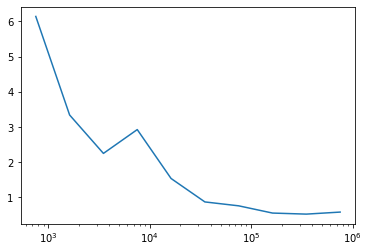

In [28]:
plt.plot(results_df.groupby("log10(E_true)").describe()[("theta_deg", "std")])
plt.semilogx()

[]

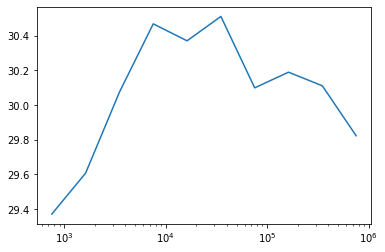

In [29]:
plt.plot(results_df.groupby("log10(E_true)").describe()[("theta_deg", "mean")])
plt.semilogx()

In [24]:
np.degrees(theta)

29.999999999999996

In [107]:
print(np.log10(amp_gen), pos, theta, phi)

10.122215878272826 [50.         28.86751346  0.        ] 0.5235987755982988 0.17453292519943295


In [29]:
scipy.stats.circstd(results_df["phi"])

0.0005827871394104359

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


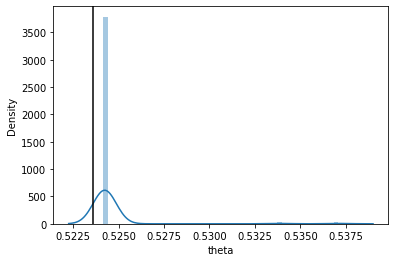

In [46]:
sns.distplot(results_df["theta"])
plt.axvline(theta, color="k")

Text(0, 0.5, 'LLH')

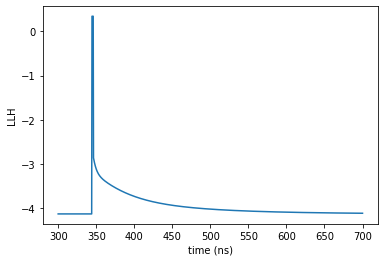

In [365]:
xs = np.linspace(300, 700, 1000)
xs_t = torch.tensor(xs, device=device, dtype=torch.float)
pdf_val, p = eval_dist(xs_t, amp_gen_t, pos_t, theta_t, phi_t, t0_gen, 30)

plt.plot(xs, pdf_val.detach().cpu())
plt.xlabel("time (ns)")
plt.ylabel("LLH")

In [35]:
def make_wrap(event, module_positions, lh_func, net):
    def wrap(logamp, theta, phi, pos_x, pos_y, pos_z, t0):
        pos = torch.stack([pos_x, pos_y, pos_z])
        res = lh_func(net, event, 10 ** logamp, pos, theta, phi, t0, module_positions)
        return res

    return wrap


def make_wrap_no_t(event, module_positions, lh_func, net):
    def wrap(logamp, theta, phi, pos_x, pos_y, pos_z):
        pos = torch.stack([pos_x, pos_y, pos_z])
        res = lh_func(net, event, 10 ** logamp, pos, theta, phi, 0, module_positions)
        return res

    return wrap


def unpack_hessian(hess):
    hess_len = len(hess)
    out = np.empty((hess_len, hess_len))
    for i in range(len(hess)):
        for j in range(len(hess)):
            out[i, j] = hess[i][j].detach().cpu().numpy()
    return out

In [423]:
hessians_f = []
for seed in range(200):
    event, record = generate_cascade_amplitudes(
        det,
        pos,
        t0_gen,
        cdir,
        n_photons=amp_gen,
        pprop_func=gen_ph_binned,
        pprop_extras=dict(),
        seed=seed,
    )
    wrap = make_wrap_no_t(event, module_positions, eval_binned_likelihood, binned_net)
    # hess = hessian(wrap, (torch.log10(amp_gen_t), theta_t, phi_t, pos_t[0], pos_t[1], pos_t[2], t0_gen_t), strict=True)
    jac = torch.stack(
        jacobian(
            wrap,
            (torch.log10(amp_gen_t), theta_t, phi_t, pos_t[0], pos_t[1], pos_t[2]),
            strict=True,
        )
    )
    # hessians.append(unpack_hessian(hess))
    hessians_f.append((jac[np.newaxis, :] * jac[:, np.newaxis]).detach().cpu().numpy())

In [424]:
hess_mf = np.average(hessians_f, axis=0)
np.sqrt(np.diag(np.linalg.inv(hess_mf)))

array([0.00640608, 0.0417094 , 0.04962471, 0.61193063, 0.58673644,
       0.07276148])

In [11]:
def make_llh_func_builder(lh_func, net, binning):
    def make_llh_func(event, module_positions):
        def llh_func(log10nergy, theta, phi, pos_x, pos_y, pos_z, t0):
            pos = torch.stack([pos_x, pos_y, pos_z])
            res = lh_func(
                net, binning, event, 10 ** log10nergy, pos, theta, phi, t0, module_positions
            )
            return res

        return llh_func

    return make_llh_func


def calc_fisher_information(n_events, det, event_params, gen_func, llh_func_builder):

    fishers = []
    for seed in range(n_events):

        event_dir = sph_to_cart_np(event_params["theta"], event_params["phi"])
        event, record = gen_func(
            det,
            event_params["pos"],
            event_params["t0"],
            event_dir,
            energy=event_params["energy"],
            seed=seed,
        )

        module_positions = torch.tensor(
            det.module_coords, dtype=torch.float, device=device
        )

        llh_func = llh_func_builder(event, module_positions)
        # wrap = make_wrap(event, module_positions, eval_likelihood, net)
        # hess = hessian(wrap, (torch.log10(amp_gen_t), theta_t, phi_t, pos_t[0], pos_t[1], pos_t[2], t0_gen_t), strict=True)
        jac = torch.stack(
            jacobian(
                llh_func,
                (
                    torch.log10(torch.tensor(event_params["energy"], device=device)),
                    torch.tensor(event_params["theta"], device=device),
                    torch.tensor(event_params["phi"], device=device),
                    torch.tensor(event_params["pos"][0], device=device),
                    torch.tensor(event_params["pos"][1], device=device),
                    torch.tensor(event_params["pos"][2], device=device),
                    torch.tensor(event_params["t0"], device=device),
                ),
                strict=True,
            )
        ).detach()

        fishers.append((jac[np.newaxis, :] * jac[:, np.newaxis]).cpu().numpy())
        torch.cuda.empty_cache()
    return np.average(fishers, axis=0)

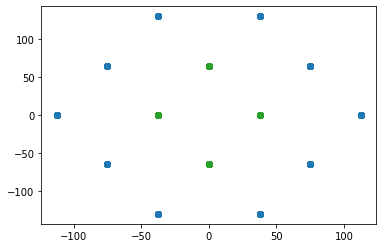

In [12]:
hex_det = Detector(
    make_hex_grid(3, 75, 20, 50, 16 * 1e-5, rng=np.random.RandomState(0))
)
positions = hex_det.module_coords
plt.scatter(positions[:, 0], positions[:, 1])

triang_det = make_triang(75, 20, 50, 16 * 1e-5, rng=np.random.RandomState(0))
positions = triang_det.module_coords
plt.scatter(positions[:, 0], positions[:, 1])

rhombus_det = make_rhombus(75, 20, 50, 16 * 1e-5, rng=np.random.RandomState(0))
positions = rhombus_det.module_coords
plt.scatter(positions[:, 0], positions[:, 1])

In [14]:
spacings = [75, 100, 150]
energies = np.logspace(3, 6, 10)
oms_per_line = 20
dist_z = 50
dark_noise_rate = 1E-6 * 16
rng = np.random.RandomState(0)
tts_grid = [0, 2, 3, 4]


event_params = {
    #"pos": np.asarray([50.0, side_len / (2 * np.sqrt(3)), 0]),
    "pos": np.asarray([0, 0, 0.]),
    "t0": 30.0,
    "energy": 1e5,
    "theta": np.radians(40),
    "phi": np.radians(30),
}

fi_data = []

detectors = {"tri": triang_det, "hex": hex_det, "rhomb": rhombus_det}


for tts in tts_grid:
    net_file = f"../hyperion/data/arrival_hist_net_{tts}tts.dat"
    binned_net, binning = torch.load(net_file)
    binned_net.to(device)
    binning = binning.to(device)
    binned_net.eval()
    
    llh_func_builder = make_llh_func_builder(eval_binned_likelihood, binned_net, binning)
    amp_gen, _ = make_generate_bin_amplitudes_nn(net_file)
   
    generate_cascade_amplitudes = make_generate_cascade_amplitudes(amp_gen)

    for spacing in spacings:

        det_triang = make_triang(spacing, oms_per_line, dist_z, dark_noise_rate, rng)
        det_hex = Detector(
            make_hex_grid(3, spacing, oms_per_line, dist_z, dark_noise_rate, rng=rng)
        )

        det_rhomb = make_rhombus(spacing, oms_per_line, dist_z, dark_noise_rate, rng=rng)


        for energy in energies:
            ev_par = dict(event_params)
            ev_par["energy"] = energy
            
            for det_key, det in detectors.items():
                fi = calc_fisher_information(
                    300, det, ev_par, generate_cascade_amplitudes, llh_func_builder
                )
           
                fi_data.append((spacing, energy, tts, det_key, fi))
        

In [15]:
cr_data = []
for (spacing, energy, tts, det_key, fi) in fi_data:
    cr = np.sqrt(np.diag(np.linalg.inv(fi)))
    cr_data.append([spacing, energy, tts, det_key] + list(cr))
   
    
df = pd.DataFrame(cr_data, columns=["spacing", "energy_sim", "tts", "geom", "log10(energy/GeV)", "theta", "phi", "x", "y", "z", "t"])
df["theta_deg"] = np.degrees(df["theta"])
df["phi_deg"] = np.degrees(df["phi"])
df.set_index("energy_sim", inplace=True)
#df.groupby("spacing")[["theta res tri", "theta res hex"]].plot(subplots=False, legend=True, logx=True)
#plt.semilogx()
    

[-0.50526238  0.57269658]


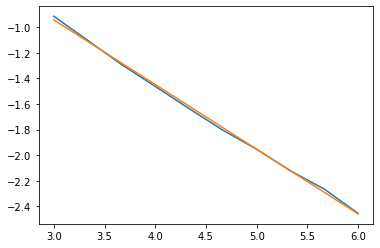

In [23]:
sel = df[(df["spacing"] == 75) & (df["tts"] == 0) & (df["geom"] == "tri")]

fitpars = np.polyfit(np.log10(sel.index), np.log10(sel["phi"]), deg=1)
print(fitpars)
plt.plot(np.log10(sel.index), np.log10(sel["phi"]))

xs = np.linspace(3, 6, 100)
plt.plot(xs, np.poly1d(fitpars)(xs))

array([-0.49714399,  4.66173696])

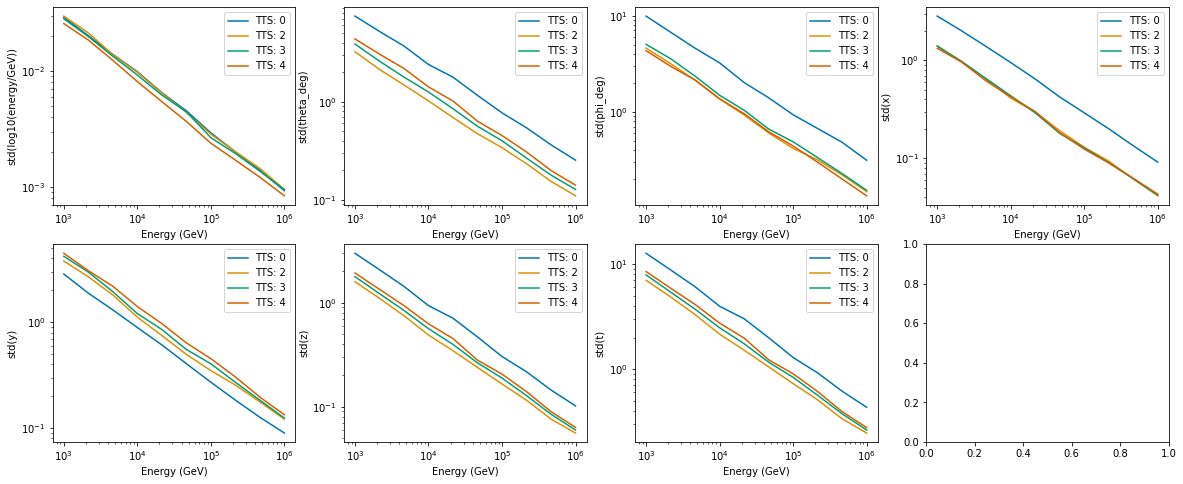

In [16]:
fig, axs = plt.subplots(2, 4, figsize=(5*4, 4*2))
colors = sns.color_palette("colorblind")
for i, (grpn, group) in enumerate(df.groupby(["spacing", "geom", "tts"])):
    if (grpn[1] != "tri") or (grpn[0] != 100):
        continue

    for colname, ax in zip(["log10(energy/GeV)", "theta_deg", "phi_deg", "x", "y", "z", "t"], axs.ravel()):

        ax.plot(group.index, group[colname], label=f"TTS: {grpn[2]}", ls="-", color=colors[i%4])
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.legend()
        ax.set_ylabel(f"std({colname})")
        ax.set_xlabel("Energy (GeV)")

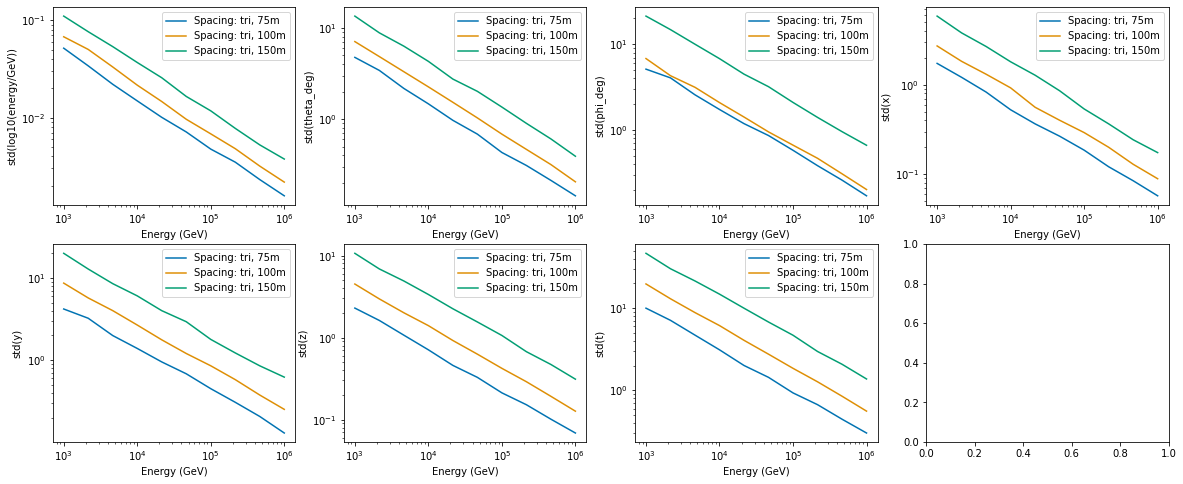

In [98]:
fig, axs = plt.subplots(2, 4, figsize=(5*4, 4*2))
colors = sns.color_palette("colorblind")
for i, (grpn, group) in enumerate(df.groupby(["spacing", "geom"])):
    for colname, ax in zip(["log10(energy/GeV)", "theta_deg", "phi_deg", "x", "y", "z", "t"], axs.ravel()):
        if grpn[1] != "tri":
            continue
        
        ax.plot(group.index, group[colname], label=f"Spacing: {grpn[1]}, {grpn[0]}m", ls=ls, color=colors[i//3])
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.legend()
        ax.set_ylabel(f"std({colname})")
        ax.set_xlabel("Energy (GeV)")

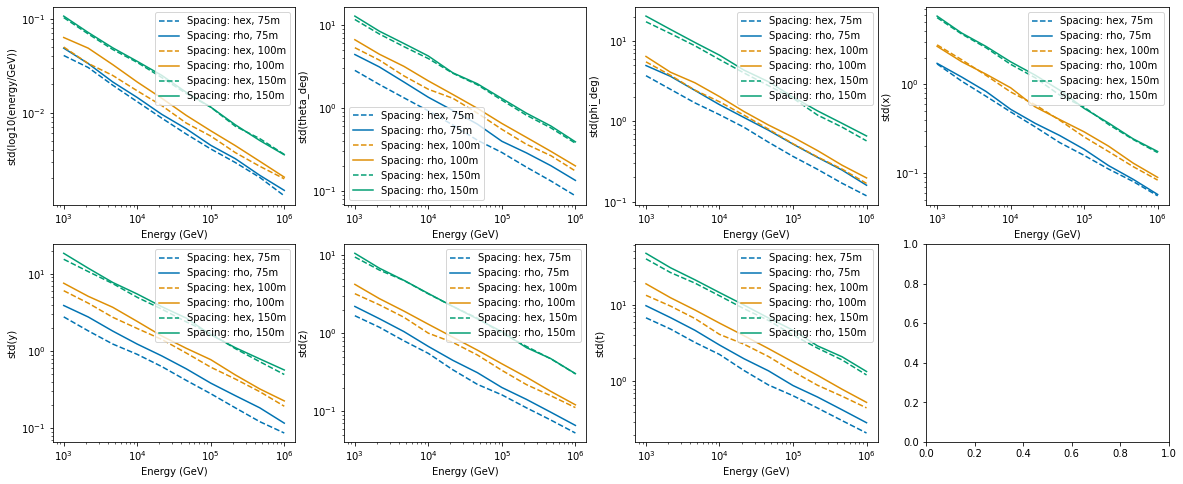

In [96]:
fig, axs = plt.subplots(2, 4, figsize=(5*4, 4*2))
colors = sns.color_palette("colorblind")
for i, (grpn, group) in enumerate(df.groupby(["spacing", "geom"])):
    for colname, ax in zip(["log10(energy/GeV)", "theta_deg", "phi_deg", "x", "y", "z", "t"], axs.ravel()):
        if grpn[1] == "tri":
            continue
        if grpn[1] == "hex":
            ls = "--"
        else:
            ls = "-"
        ax.plot(group.index, group[colname], label=f"Spacing: {grpn[1]}, {grpn[0]}m", ls=ls, color=colors[i//3])
        ax.set_xscale("log")
        ax.set_yscale("log")
        ax.legend()
        ax.set_ylabel(f"std({colname})")
        ax.set_xlabel("Energy (GeV)")

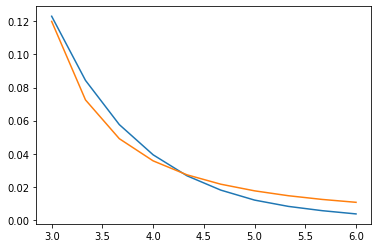

In [89]:
xs = df[(df["spacing"] == 100) & (df["geom"] == "tri")].index
ys = df[(df["spacing"] == 100) & (df["geom"] == "tri")]["theta"]

plt.plot(np.log10(xs), ys)

ytest = 1/(np.log10(xs)-2)**(1.75) * 0.12
plt.plot(np.log10(xs), ytest)


In [50]:
event_params = {
    "pos": np.asarray([0.0, 0, 0]),
    "t0": 30.0,
    "energy": 1e5,
    "theta": np.radians(40),
    "phi": np.radians(30),
}
llh_func_builder = make_llh_func_builder(eval_binned_likelihood, binned_net)
fi = calc_fisher_information(
    100, det, event_params, generate_cascade_amplitudes, llh_func_builder
)

In [51]:
crao = np.sqrt(np.diag(np.linalg.inv(fi)))
print(crao)

[0.00388254 0.00329877 0.01236468 0.49744192 0.82622378 0.14601518
 0.6610854 ]


In [438]:
spacings = [75, 100, 150]

all_spacings = []
for spacing in spacings:

    det = make_triang(spacing, oms_per_line, dist_z, dark_noise_rate, rng)
    module_positions = torch.tensor(det.module_coords, dtype=torch.float, device=device)

    all_hessians = []
    hessians = []
    hessians_f = []

    all_n_photons_gen = np.logspace(8, 11, 10)
    for amp_gen in all_n_photons_gen:
        amp_gen_t = torch.tensor(amp_gen, device=device, dtype=torch.float)
        hessians_f = []
        for seed in range(300):
            event, record = generate_cascade(
                det, pos, t0_gen, cdir, n_photons=amp_gen, pprop_func=gen_ph
            )
            wrap = make_wrap(event, module_positions, eval_likelihood, net)
            # hess = hessian(wrap, (torch.log10(amp_gen_t), theta_t, phi_t, pos_t[0], pos_t[1], pos_t[2], t0_gen_t), strict=True)
            jac = torch.stack(
                jacobian(
                    wrap,
                    (
                        torch.log10(amp_gen_t),
                        theta_t,
                        phi_t,
                        pos_t[0],
                        pos_t[1],
                        pos_t[2],
                        t0_gen_t,
                    ),
                    strict=True,
                )
            ).detach()
            # hessians.append(unpack_hessian(hess))
            hessians_f.append((jac[np.newaxis, :] * jac[:, np.newaxis]).cpu().numpy())
            torch.cuda.empty_cache()
        all_hessians.append(hessians_f)
    all_spacings.append(all_hessians)
hess_mf = np.average(all_spacings, axis=2)

[0.29203663 0.15352676 0.07936085 0.04020268 0.02459871 0.01465636
 0.00941159 0.00619484 0.00422443 0.00296597]
[0.35885288 0.17311612 0.08284528 0.04271057 0.02532418 0.0168706
 0.01103634 0.00736033 0.00469894 0.00315145]
[0.33953496 0.14922656 0.06687566 0.03574517 0.02119206 0.01353288
 0.00803545 0.00567125 0.00387631 0.00295389]


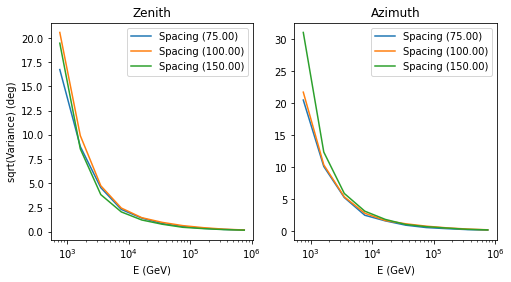

In [439]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for i, spacing in enumerate(spacings):
    all_inv = np.asarray(
        [np.sqrt(np.diag(np.linalg.inv(hess_mf[i, j]))) for j in range(10)]
    )
    print(all_inv[:, 1])
    axs[0].plot(
        all_n_photons_gen / (5.3 * 250 * 1e2),
        np.degrees(all_inv[:, 1]),
        label=f"Spacing ({spacing:.2f})",
    )
    axs[1].plot(
        all_n_photons_gen / (5.3 * 250 * 1e2),
        np.degrees(all_inv[:, 2]),
        label=f"Spacing ({spacing:.2f})",
    )
axs[0].set_xscale("log")
axs[1].set_xscale("log")
axs[0].set_xlabel("E (GeV)")
axs[1].set_xlabel("E (GeV)")
axs[0].legend()
axs[1].legend()
axs[0].set_ylabel("sqrt(Variance) (deg)")
axs[0].set_title("Zenith")
axs[1].set_title("Azimuth")
plt.savefig("figures/cramer_rao_example.png", dpi=250)

In [33]:
fisher_results = {}

spacings = [75, 100, 150]

all_spacings = []
for spacing in spacings:

    det = make_triang(spacing, oms_per_line, dist_z, dark_noise_rate, rng)
    module_positions = torch.tensor(det.module_coords, dtype=torch.float, device=device)

    all_hessians = []
    hessians = []
    hessians_f = []

    all_n_photons_gen = np.logspace(8, 11, 10)
    for amp_gen in all_n_photons_gen:
        amp_gen_t = torch.tensor(amp_gen, device=device, dtype=torch.float)
        hessians_f = []
        for seed in range(300):
            event, record = generate_cascade_amplitudes(
                det,
                pos,
                t0_gen,
                cdir,
                n_photons=amp_gen,
                pprop_func=gen_ph_binned,
                seed=seed,
            )
            wrap = make_wrap_no_t(
                event, module_positions, eval_binned_likelihood, binned_net
            )
            # hess = hessian(wrap, (torch.log10(amp_gen_t), theta_t, phi_t, pos_t[0], pos_t[1], pos_t[2], t0_gen_t), strict=True)
            jac = torch.stack(
                jacobian(
                    wrap,
                    (
                        torch.log10(amp_gen_t),
                        theta_t,
                        phi_t,
                        pos_t[0],
                        pos_t[1],
                        pos_t[2],
                    ),
                    strict=True,
                )
            ).detach()
            # hessians.append(unpack_hessian(hess))
            hessians_f.append((jac[np.newaxis, :] * jac[:, np.newaxis]).cpu().numpy())
            torch.cuda.empty_cache()
        all_hessians.append(hessians_f)
    all_spacings.append(all_hessians)
hess_mf = np.average(all_spacings, axis=2)

fisher_results["triang"] = hess_mf

[0.26548343 0.19476233 0.1293747  0.08379738 0.05960499 0.0406361
 0.02742459 0.01802186 0.01207399 0.00877168]
[0.21949468 0.15528418 0.10474151 0.06984114 0.05282469 0.03552592
 0.02304198 0.01563723 0.01022622 0.00712899]
[0.30585934 0.20972301 0.13949619 0.09349603 0.06681366 0.04516109
 0.02937323 0.01990406 0.0133326  0.0094935 ]


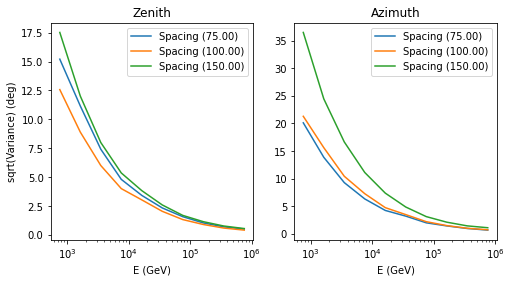

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for i, spacing in enumerate(spacings):
    all_inv = np.asarray(
        [np.sqrt(np.diag(np.linalg.inv(hess_mf[i, j]))) for j in range(10)]
    )
    print(all_inv[:, 1])
    axs[0].plot(
        all_n_photons_gen / (5.3 * 250 * 1e2),
        np.degrees(all_inv[:, 1]),
        label=f"Spacing ({spacing:.2f})",
    )
    axs[1].plot(
        all_n_photons_gen / (5.3 * 250 * 1e2),
        np.degrees(all_inv[:, 2]),
        label=f"Spacing ({spacing:.2f})",
    )
axs[0].set_xscale("log")
axs[1].set_xscale("log")
axs[0].set_xlabel("E (GeV)")
axs[1].set_xlabel("E (GeV)")
axs[0].legend()
axs[1].legend()
axs[0].set_ylabel("sqrt(Variance) (deg)")
axs[0].set_title("Zenith")
axs[1].set_title("Azimuth")
plt.savefig("figures/cramer_rao_example.png", dpi=250)

[0.12461976 0.08538367 0.061878   0.04293092 0.02906864 0.01896312
 0.01287025 0.00940793 0.00626487 0.00433612]
[0.22017373 0.14380359 0.09953116 0.06781219 0.04670058 0.03223904
 0.01981022 0.01387001 0.01014153 0.00640564]
[0.44161591 0.30613019 0.21346263 0.14128561 0.10170861 0.06946233
 0.04703779 0.03149673 0.02178245 0.01412427]


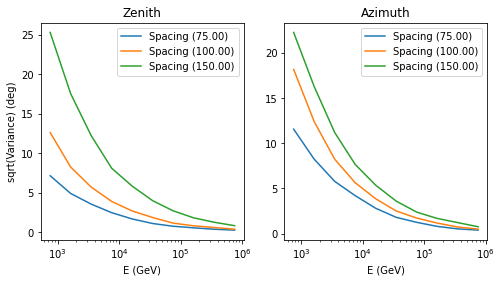

In [57]:
spacings = [75, 100, 150]

all_spacings = []
for spacing in spacings:

    det = Detector(
        make_hex_grid(3, spacing, 20, 50, 16 * 1e-5, rng=np.random.RandomState(0))
    )
    module_positions = torch.tensor(det.module_coords, dtype=torch.float, device=device)

    all_hessians = []
    hessians = []
    hessians_f = []

    all_n_photons_gen = np.logspace(8, 11, 10)
    for amp_gen in all_n_photons_gen:
        amp_gen_t = torch.tensor(amp_gen, device=device, dtype=torch.float)
        hessians_f = []
        for seed in range(300):
            event, record = generate_cascade_amplitudes(
                det,
                pos,
                t0_gen,
                cdir,
                n_photons=amp_gen,
                pprop_func=gen_ph_binned,
                seed=seed,
            )
            wrap = make_wrap_no_t(
                event, module_positions, eval_binned_likelihood, binned_net
            )
            # hess = hessian(wrap, (torch.log10(amp_gen_t), theta_t, phi_t, pos_t[0], pos_t[1], pos_t[2], t0_gen_t), strict=True)
            jac = torch.stack(
                jacobian(
                    wrap,
                    (
                        torch.log10(amp_gen_t),
                        theta_t,
                        phi_t,
                        pos_t[0],
                        pos_t[1],
                        pos_t[2],
                    ),
                    strict=True,
                )
            ).detach()
            # hessians.append(unpack_hessian(hess))
            hessians_f.append((jac[np.newaxis, :] * jac[:, np.newaxis]).cpu().numpy())
            torch.cuda.empty_cache()
        all_hessians.append(hessians_f)
    all_spacings.append(all_hessians)
hess_mf = np.average(all_spacings, axis=2)

fig, axs = plt.subplots(1, 2, figsize=(8, 4))
for i, spacing in enumerate(spacings):
    all_inv = np.asarray(
        [np.sqrt(np.diag(np.linalg.inv(hess_mf[i, j]))) for j in range(10)]
    )
    print(all_inv[:, 1])
    axs[0].plot(
        all_n_photons_gen / (5.3 * 250 * 1e2),
        np.degrees(all_inv[:, 1]),
        label=f"Spacing ({spacing:.2f})",
    )
    axs[1].plot(
        all_n_photons_gen / (5.3 * 250 * 1e2),
        np.degrees(all_inv[:, 2]),
        label=f"Spacing ({spacing:.2f})",
    )
axs[0].set_xscale("log")
axs[1].set_xscale("log")
axs[0].set_xlabel("E (GeV)")
axs[1].set_xlabel("E (GeV)")
axs[0].legend()
axs[1].legend()
axs[0].set_ylabel("sqrt(Variance) (deg)")
axs[0].set_title("Zenith")
axs[1].set_title("Azimuth")
plt.savefig("figures/cramer_rao_example.png", dpi=250)

In [552]:
np.degrees(np.sqrt(np.linalg.inv(hess_mf)[1, 1]))

0.9208471

In [553]:
np.degrees(np.sqrt(np.linalg.inv(hess_mf)[2, 2]))

1.3092561

In [449]:
np.degrees(np.sqrt(np.linalg.inv(-hess_m)[2, 2]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


nan

In [339]:
model_in = source_to_model_input(det.module_coords, [phsrc])

xs = np.linspace(0, 100, 1000)
xs_t = torch.tensor(xs, device=device, dtype=torch.float)

plt.plot(
    xs, torch.exp(uniform_triple_exp(xs_t, pdf_params)[:, 30]).detach().cpu(), color="r"
)

# times =
# sns.histplot(times, bins = np.linspace(0, 100, 100), stat="density")
# plt.semilogy()

TypeError: source_to_model_input() missing 2 required positional arguments: 'c_vac' and 'n_gr'

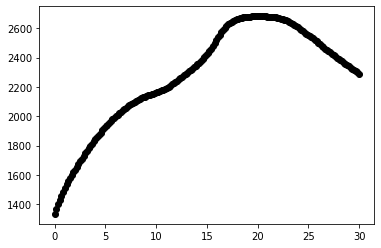

In [58]:
thetas = torch.linspace(np.radians(0), np.radians(30), 180)
for theta in thetas:
    plt.plot(
        np.degrees(theta.cpu().detach()),
        eval_dist(event2, 0.3 * 1e9, pos, theta, phi).cpu().detach(),
        "ok",
    )

In [32]:
def wrap(theta, phi):
    return eval_dist(event, 1e6, pos, theta, phi)


theta = torch.tensor(20.0, device=device)  #
phi = torch.tensor(0.0, device=device)
hess = hessian(wrap, (theta, phi), strict=True)

In [33]:
hess

((tensor(-3.4984, device='cuda:0'), tensor(1.6891, device='cuda:0')),
 (tensor(1.6891, device='cuda:0'), tensor(2.5304, device='cuda:0')))

In [24]:
hessian(
    lambda theta, phi: net(
        source_to_model_input(module_positions, pos, sph_to_cart(theta, phi))
    )
    .reshape(module_positions.shape[0], 7)
    .sum(),
    (theta, phi),
)

((tensor(0., device='cuda:0'), tensor(0., device='cuda:0')),
 (tensor(0., device='cuda:0'), tensor(0., device='cuda:0')))

In [228]:
xs = torch.linspace(0, 200, 1000, device=device)
plt.plot(xs.detach().cpu(), uniform_triple_exp(xs, pdf_params[10, :-1]).detach().cpu())
plt.plot(xs.detach().cpu(), uniform_triple_exp(xs, pdf_params2[10, :-1]).detach().cpu())
# plt.semilogy()

IndexError: too many indices for tensor of dimension 1

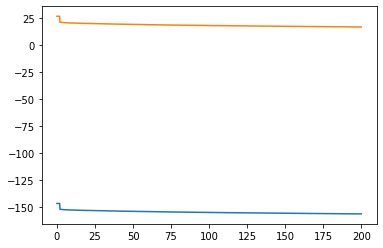

In [200]:
xs = torch.linspace(0, 200, 1000, device=device)
plt.plot(
    xs.detach().cpu(),
    poisson_utr_exp(
        1e5,
        xs,
        *pdf_params[
            10,
        ]
    )
    .detach()
    .cpu(),
)
plt.plot(
    xs.detach().cpu(),
    poisson_utr_exp(
        1e5,
        xs,
        *pdf_params2[
            10,
        ]
    )
    .detach()
    .cpu(),
)
# plt.semilogy()

In [139]:
torch.autograd.functional.hessian

tensor(0.0153, device='cuda:0', grad_fn=<RsubBackward1>)

In [126]:
pdf_params2[0]

tensor([ 0.1407,  0.4384,  0.7594,  0.7884,  0.6862,  0.0066, -6.5473],
       device='cuda:0', grad_fn=<SelectBackward>)

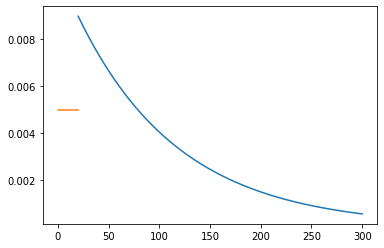

In [179]:
xs = np.linspace(0, 300, 1000)
plt.plot(xs[xs > 20], 0.9 * 1 / 100 * np.exp((-(xs[xs > 20] - 20) / 100)))
plt.plot(xs[xs < 20], 0.1 * 1 / 20 * np.ones((xs < 20).sum()))

In [180]:
def func(xs):
    xs = np.atleast_1d(xs)
    out = np.empty_like(xs)
    out[xs > 20] = 0.9 * 1 / 100 * np.exp((-(xs[xs > 20] - 20)) / 100)
    out[xs <= 20] = 0.1 * 1 / 20 * np.ones((xs <= 20).sum())
    return out

In [181]:
from scipy.integrate import quad

In [183]:
quad(func, 0, 1000)

(0.9999500936055827, 1.4619977228846892e-08)

In [178]:
quad(lambda xs: 0.9 * 1 / 100 * np.exp((-xs / 100)), 10, 1000)

(0.8143128162955776, 1.7995457225188243e-14)